In [1]:
import torch
import os
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import normalize
import scipy
from PIL import ImageOps
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision
from torchvision import transforms
from matplotlib import cm

REBUILD_DATA = False

In [2]:
training_data = np.load('training_data_alex.npy', allow_pickle=True)

In [3]:
if REBUILD_DATA:
    # Create rotated set
    training_data_rotated = []
    for img in training_data:
        training_data_rotated.append(img)
        for i in range(1,13):
            training_data_rotated.append([scipy.ndimage.rotate(img[0], i, reshape=False), img[1].reshape(1000)])


    # Create flipped set
    training_data_r_f = []
    for img in training_data_rotated:
        training_data_r_f.append(img)
        training_data_r_f.append([np.fliplr(img[0]), img[1]])

    # remove un-needed noise
#     def dumb_remover(img):
#         better_img = np.ndarray((224, 224, 3))
#         for row in range(len(img)):
#             for col in range(len(img[row])):
#                 better_img[row][col] = img[row][col]
                
#         return better_img


#     for i in tqdm(range(len(training_data_r_f))):
#         training_data_r_f[i][0] = dumb_remover(training_data_r_f[i][0]).reshape(224, 224, 3)
        

In [4]:
# normalise
rgb_norm_mean = [0.485, 0.456, 0.406]
rgb_norm_std = [0.229, 0.224, 0.225]
for example in training_data_r_f:
    example[0] = example[0]/255.0
    example[0] = (example[0] - rgb_norm_mean)/rgb_norm_std

NameError: name 'training_data_r_f' is not defined

In [ ]:
# shuffle for good luck
np.random.shuffle(training_data_r_f)

# Save
np.save('training_data_rotated_and_flipped_alex.npy', training_data_r_f)

In [5]:
training_data = np.load('training_data_rotated_and_flipped_alex.npy', allow_pickle=True)

In [6]:
X = torch.Tensor([i[0] for i in training_data]).view(-1, 224, 224, 3)
print("X shape: ", X.shape)

y = torch.Tensor([i[1] for i in training_data])
print("y shape: ", y.shape)

VAL_PCT = 0.4
val_size = int(len(X)*VAL_PCT)
print(len(X), val_size)

X shape:  torch.Size([5538, 224, 224, 3])
y shape:  torch.Size([5538, 1000])
5538 2215


In [7]:
training_data.astype(np.float)
# X1 = torch.from_numpy(training_data)

ValueError: setting an array element with a sequence.

In [9]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

3323
2215


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


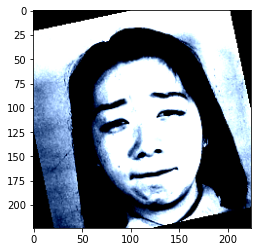

tensor([[[-2.1179, -2.0357, -1.8044],
         [-2.1179, -2.0357, -1.8044],
         [-2.1179, -2.0357, -1.8044],
         ...,
         [-2.1179, -2.0357, -1.8044],
         [-2.1179, -2.0357, -1.8044],
         [-2.1179, -2.0357, -1.8044]],

        [[-2.1179, -2.0357, -1.8044],
         [-2.1179, -2.0357, -1.8044],
         [-2.1179, -2.0357, -1.8044],
         ...,
         [-2.1179, -2.0357, -1.8044],
         [-2.1179, -2.0357, -1.8044],
         [-2.1179, -2.0357, -1.8044]],

        [[-2.1179, -2.0357, -1.8044],
         [-2.1179, -2.0357, -1.8044],
         [-2.1179, -2.0357, -1.8044],
         ...,
         [-2.1179, -2.0357, -1.8044],
         [-2.1179, -2.0357, -1.8044],
         [-2.1179, -2.0357, -1.8044]],

        ...,

        [[-2.1179, -2.0357, -1.8044],
         [-2.1179, -2.0357, -1.8044],
         [-2.1179, -2.0357, -1.8044],
         ...,
         [-2.1179, -2.0357, -1.8044],
         [-2.1179, -2.0357, -1.8044],
         [-2.1179, -2.0357, -1.8044]],

        [[

In [10]:
plt.imshow(test_X[5].view(224, 224, 3))
plt.show()
test_X[5]

In [11]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [6]:
# modelsnet152_model_max = torch.load('C:/tmp/Ari_Models_Resnet152.pt')
resnet152 = models.resnet152(pretrained=False)
resnet152.to(device)
optimizer = optim.Adam(resnet152.parameters(), lr=0.001)

checkpoint = torch.load('C:/tmp/Ari_Models_Resnet152_current.pt')
resnet152.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [ ]:
# resnet152 = nn.DataParallel(resnet152)
resnet152.to(device)

In [7]:
EPOCHS = 30
BATCH_SIZE = 16

# optimizer = optim.Adam(resnet152.parameters(), lr=0.001)
loss_function = nn.MSELoss()

loss_outsample = []
acc = []
loss_insample = []

max_accuracy = 0
min_loss = 10

resnet152_model_max = resnet152

for epoch in tqdm(range(EPOCHS)):
    resnet152.train()
    for i in range(0, len(train_X), BATCH_SIZE):
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 3, 224, 224)
        batch_y = train_y[i:i+BATCH_SIZE]
        
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        resnet152.zero_grad()
        outputs = resnet152(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
    
    correct = 0
    total = 0
    mean_loss = 0
    
    resnet152.eval()
    with torch.no_grad():
        for i in range(len(test_X)):
            real_class = torch.argmax(test_y[i]).to(device)
            model_out = resnet152(test_X[i].view(-1, 3, 224, 224).to(device))[0]
            predicted_class = torch.argmax(model_out)
#             print(predicted_class, real_class)
            loss_test = loss_function(model_out, test_y[i].to(device))
            mean_loss += loss_test
            if predicted_class == real_class:
                correct += 1
            total += 1
    accuracy = round(correct/total, 3)
    acc.append(accuracy)
    print("Out/Sample Accuracy: ", accuracy)
    loss_outsample.append(loss_test)
    loss_insample.append(loss)
#     mean_loss = mean_loss/(len(test_X)) ### for clarity in graph ###
    torch.save({
        'epoch': epoch,
        'model_state_dict': resnet152.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'accuracy': accuracy,
    }, f'C:/tmp/Ari_Models_Resnet152_current.pt')
    print("In/Loss: ", loss)
    print("Out/Loss: ", mean_loss)
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        min_loss = loss
        resnet152_model_max = resnet152
    elif accuracy == max_accuracy and (loss < min_loss):
        min_loss = loss
        resnet152_model_max = resnet152
torch.save({
    'model_state_dict': resnet152_model_max.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': min_loss,
    'accuracy': max_accuracy,
}, f'C:/tmp/Ari_Models_Resnet152_best-{str(max_accuracy).replace(".", "_")}.pt')

  0%|                                                                                                                                                                                                        | 0/30 [00:00<?, ?it/s]

Out/Sample Accuracy:  0.971


  3%|██████▎                                                                                                                                                                                      | 1/30 [03:00<1:27:00, 180.03s/it]

In/Loss:  tensor(3.9436e-07, device='cuda:1', grad_fn=<MseLossBackward>)
Out/Loss:  tensor(0.0052, device='cuda:1')
Out/Sample Accuracy:  0.945


  7%|████████████▌                                                                                                                                                                                | 2/30 [05:58<1:23:46, 179.53s/it]

In/Loss:  tensor(2.1914e-06, device='cuda:1', grad_fn=<MseLossBackward>)
Out/Loss:  tensor(0.0189, device='cuda:1')
Out/Sample Accuracy:  0.831


 10%|██████████████████▉                                                                                                                                                                          | 3/30 [08:54<1:20:20, 178.52s/it]

In/Loss:  tensor(6.9537e-05, device='cuda:1', grad_fn=<MseLossBackward>)
Out/Loss:  tensor(0.1280, device='cuda:1')
Out/Sample Accuracy:  0.85


 13%|█████████████████████████▏                                                                                                                                                                   | 4/30 [11:52<1:17:17, 178.35s/it]

In/Loss:  tensor(3.3696e-05, device='cuda:1', grad_fn=<MseLossBackward>)
Out/Loss:  tensor(0.1010, device='cuda:1')
Out/Sample Accuracy:  0.949


 17%|███████████████████████████████▌                                                                                                                                                             | 5/30 [14:47<1:13:55, 177.41s/it]

In/Loss:  tensor(3.3843e-06, device='cuda:1', grad_fn=<MseLossBackward>)
Out/Loss:  tensor(0.0181, device='cuda:1')
Out/Sample Accuracy:  0.935


 20%|█████████████████████████████████████▊                                                                                                                                                       | 6/30 [17:43<1:10:48, 177.04s/it]

In/Loss:  tensor(5.3574e-06, device='cuda:1', grad_fn=<MseLossBackward>)
Out/Loss:  tensor(0.0248, device='cuda:1')
Out/Sample Accuracy:  0.952


 23%|████████████████████████████████████████████                                                                                                                                                 | 7/30 [20:42<1:08:01, 177.47s/it]

In/Loss:  tensor(1.9121e-06, device='cuda:1', grad_fn=<MseLossBackward>)
Out/Loss:  tensor(0.0202, device='cuda:1')
Out/Sample Accuracy:  0.971


 27%|██████████████████████████████████████████████████▍                                                                                                                                          | 8/30 [23:40<1:05:08, 177.64s/it]

In/Loss:  tensor(1.1171e-06, device='cuda:1', grad_fn=<MseLossBackward>)
Out/Loss:  tensor(0.0062, device='cuda:1')
Out/Sample Accuracy:  0.975


 30%|████████████████████████████████████████████████████████▋                                                                                                                                    | 9/30 [26:38<1:02:15, 177.87s/it]

In/Loss:  tensor(7.1010e-07, device='cuda:1', grad_fn=<MseLossBackward>)
Out/Loss:  tensor(0.0050, device='cuda:1')
Out/Sample Accuracy:  0.976


 33%|███████████████████████████████████████████████████████████████▎                                                                                                                              | 10/30 [29:37<59:20, 178.05s/it]

In/Loss:  tensor(5.5453e-07, device='cuda:1', grad_fn=<MseLossBackward>)
Out/Loss:  tensor(0.0044, device='cuda:1')
Out/Sample Accuracy:  0.976


 37%|█████████████████████████████████████████████████████████████████████▋                                                                                                                        | 11/30 [32:35<56:25, 178.17s/it]

In/Loss:  tensor(4.6636e-07, device='cuda:1', grad_fn=<MseLossBackward>)
Out/Loss:  tensor(0.0040, device='cuda:1')
Out/Sample Accuracy:  0.977


 40%|████████████████████████████████████████████████████████████████████████████                                                                                                                  | 12/30 [35:34<53:30, 178.36s/it]

In/Loss:  tensor(4.1009e-07, device='cuda:1', grad_fn=<MseLossBackward>)
Out/Loss:  tensor(0.0037, device='cuda:1')
Out/Sample Accuracy:  0.977


 43%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 13/30 [38:32<50:31, 178.34s/it]

In/Loss:  tensor(3.6097e-07, device='cuda:1', grad_fn=<MseLossBackward>)
Out/Loss:  tensor(0.0035, device='cuda:1')
Out/Sample Accuracy:  0.979


 47%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 14/30 [41:30<47:27, 178.00s/it]

In/Loss:  tensor(3.2235e-07, device='cuda:1', grad_fn=<MseLossBackward>)
Out/Loss:  tensor(0.0033, device='cuda:1')
Out/Sample Accuracy:  0.98


 50%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 15/30 [44:26<44:22, 177.48s/it]

In/Loss:  tensor(2.8364e-07, device='cuda:1', grad_fn=<MseLossBackward>)
Out/Loss:  tensor(0.0032, device='cuda:1')
Out/Sample Accuracy:  0.979


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 16/30 [47:21<41:15, 176.81s/it]

In/Loss:  tensor(2.6564e-07, device='cuda:1', grad_fn=<MseLossBackward>)
Out/Loss:  tensor(0.0031, device='cuda:1')
Out/Sample Accuracy:  0.979


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 17/30 [50:16<38:10, 176.18s/it]

In/Loss:  tensor(2.3962e-07, device='cuda:1', grad_fn=<MseLossBackward>)
Out/Loss:  tensor(0.0031, device='cuda:1')
Out/Sample Accuracy:  0.98


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 18/30 [53:10<35:07, 175.58s/it]

In/Loss:  tensor(2.2054e-07, device='cuda:1', grad_fn=<MseLossBackward>)
Out/Loss:  tensor(0.0030, device='cuda:1')
Out/Sample Accuracy:  0.981


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 19/30 [56:05<32:08, 175.28s/it]

In/Loss:  tensor(1.9842e-07, device='cuda:1', grad_fn=<MseLossBackward>)
Out/Loss:  tensor(0.0030, device='cuda:1')
Out/Sample Accuracy:  0.98


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 20/30 [58:59<29:10, 175.03s/it]

In/Loss:  tensor(1.9965e-07, device='cuda:1', grad_fn=<MseLossBackward>)
Out/Loss:  tensor(0.0030, device='cuda:1')
Out/Sample Accuracy:  0.98


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 21/30 [1:01:52<26:10, 174.48s/it]

In/Loss:  tensor(1.6549e-07, device='cuda:1', grad_fn=<MseLossBackward>)
Out/Loss:  tensor(0.0029, device='cuda:1')
Out/Sample Accuracy:  0.981


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 22/30 [1:04:46<23:14, 174.25s/it]

In/Loss:  tensor(1.9632e-07, device='cuda:1', grad_fn=<MseLossBackward>)
Out/Loss:  tensor(0.0031, device='cuda:1')
Out/Sample Accuracy:  0.98


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 23/30 [1:07:39<20:17, 173.98s/it]

In/Loss:  tensor(1.3674e-07, device='cuda:1', grad_fn=<MseLossBackward>)
Out/Loss:  tensor(0.0029, device='cuda:1')
Out/Sample Accuracy:  0.98


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 24/30 [1:10:36<17:29, 174.93s/it]

In/Loss:  tensor(1.7901e-07, device='cuda:1', grad_fn=<MseLossBackward>)
Out/Loss:  tensor(0.0032, device='cuda:1')
Out/Sample Accuracy:  0.98


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 25/30 [1:13:35<14:40, 176.17s/it]

In/Loss:  tensor(1.4684e-07, device='cuda:1', grad_fn=<MseLossBackward>)
Out/Loss:  tensor(0.0029, device='cuda:1')
Out/Sample Accuracy:  0.982


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 26/30 [1:16:34<11:47, 176.96s/it]

In/Loss:  tensor(1.5195e-07, device='cuda:1', grad_fn=<MseLossBackward>)
Out/Loss:  tensor(0.0027, device='cuda:1')
Out/Sample Accuracy:  0.978


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 27/30 [1:19:30<08:49, 176.66s/it]

In/Loss:  tensor(1.4467e-07, device='cuda:1', grad_fn=<MseLossBackward>)
Out/Loss:  tensor(0.0033, device='cuda:1')
Out/Sample Accuracy:  0.983


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 28/30 [1:22:28<05:53, 176.93s/it]

In/Loss:  tensor(2.4105e-07, device='cuda:1', grad_fn=<MseLossBackward>)
Out/Loss:  tensor(0.0034, device='cuda:1')
Out/Sample Accuracy:  0.982


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 29/30 [1:25:26<02:57, 177.41s/it]

In/Loss:  tensor(2.9641e-07, device='cuda:1', grad_fn=<MseLossBackward>)
Out/Loss:  tensor(0.0033, device='cuda:1')
Out/Sample Accuracy:  0.98


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [1:28:24<00:00, 176.81s/it]

In/Loss:  tensor(3.4409e-07, device='cuda:1', grad_fn=<MseLossBackward>)
Out/Loss:  tensor(0.0046, device='cuda:1')


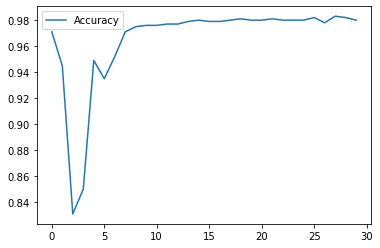

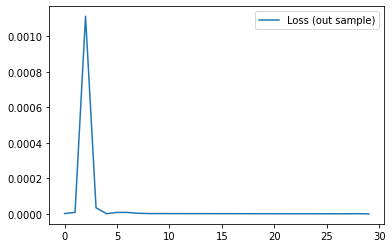

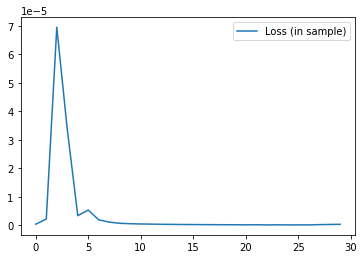

In [8]:
plt.plot(acc, label='Accuracy')
plt.legend()
plt.show()
plt.plot(loss_outsample, label='Loss (out sample)')
plt.legend()
plt.show()
plt.plot(loss_insample, label='Loss (in sample)')
plt.legend()
plt.show()

torch.save(resnet152, 'C:/tmp/Ari_Models_Resnet152_current.pt')
torch.save(resnet152_model_max, 'C:/tmp/Ari_Models_Resnet152_max.pt')

In [44]:
# modelsnet152_model_max = torch.load('C:/tmp/Ari_Models_Resnet152.pt')
loaded_45 = models.resnet152(pretrained=False)
loaded_45.to('cpu')
optimizer = optim.Adam(resnet152.parameters(), lr=0.001)

checkpoint = torch.load('C:/tmp/Ari_Models_Resnet152_best-0_983.pt')
loaded_45.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
loss = checkpoint['loss']
loaded_45.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [23]:
# loaded_45 = nn.DataParallel(loaded_45)
loaded_45.to('cpu')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [25]:
# for i in range(100):
#     out = loaded_45(test_X[i].view(-1, 3, 224, 224).to(device))[0]
#     print(torch.argmax(out), torch.argmax(test_y[i]))
#     plt.imshow(test_X[i].view(224, 224, 3))
#     plt.show()

In [40]:
resnet152_model_max.to('cpu')
example = torch.rand(1, 3, 224, 224)
resnet152_model_max.eval()
traced_script_module = torch.jit.trace(resnet152_model_max, example)
traced_script_module.save(r"C:\Users\baby yoda\dev\android-demo-app\HelloWorldApp\app\src\main\assets\my_model.pt")

In [45]:
total = 0
correct = 0
for i in tqdm(range(len(test_X))):
    out = loaded_45(test_X[i].view(-1, 3, 224, 224).to('cpu'))[0]
    if torch.argmax(out) == torch.argmax(test_y[i]):
        correct += 1
    total += 1
print(round(correct/total, 3))
        

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2215/2215 [06:10<00:00,  5.98it/s]

0.98


In [ ]:
model = torchvision.models.resnet18(pretrained=True)
model.eval()
example = torch.rand(1, 3, 224, 224)

In [ ]:
traced_script_module = torch.jit.trace(model, example)
traced_script_module.save(r"C:\Users\baby yoda\dev\android-demo-app\HelloWorldApp\app\src\main\assets\my_model.pt")